# Step0: Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

import string 
import nltk

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Step1: Loading Data

In [ ]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj5/ads-spring-2022-prj5-group-4/"
outputs_dir = root + "output/"
lib_dir = root + "lib/"

assert os.path.exists(root), 'Check the path to your root directory'
assert os.path.exists(outputs_dir), 'Check the path to your outputs directory'
assert os.path.exists(lib_dir), 'Check the path to your lib directory'

In [ ]:
data = pd.read_csv(outputs_dir+'goodreads_reviews_spoiler.csv')

In [ ]:
df = data.drop(["has_spoiler", 'Unnamed: 0'], axis=1)
df = df.rename(columns={"class": "has_spoiler"}, errors="raise")

In [ ]:
print('There are {} rows and {} columns in subset data'.format(df.shape[0],df.shape[1]))

There are 1466895 rows and 7 columns in subset data


# Step2: Exploratory Data Analysis

## Overview of original dataset

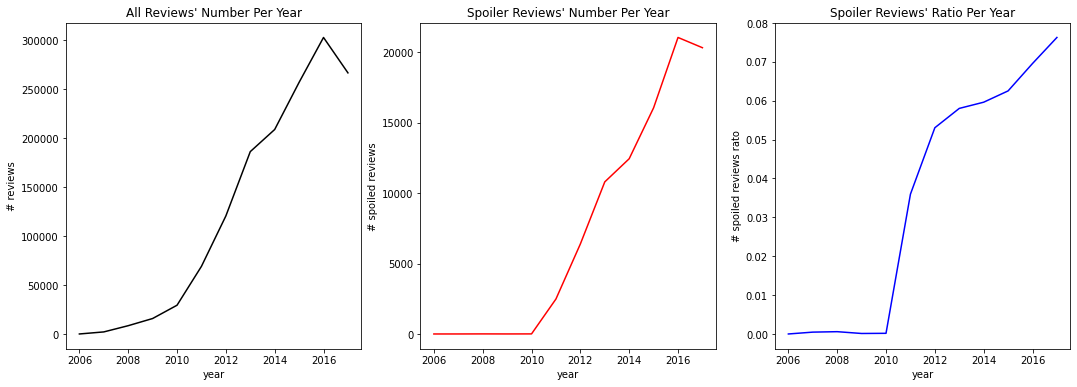

In [ ]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year.values

year_all = df.year.value_counts().reset_index().rename(columns={'index':'year', 'year':'count'})
year_spoiler =  df[df.has_spoiler == 1].year.value_counts().reset_index().rename(columns={'index':'year', 'year':'spoiler_count'})

year_ratio = year_all.merge(year_spoiler, on='year', how='left').fillna(0)
year_ratio['ratio'] = year_ratio['spoiler_count']/year_ratio['count']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(x='year', y='count', data=year_ratio, ax=ax[0], color='black')
ax[0].set_ylabel('# reviews')
ax[0].set_xlabel('year')
ax[0].set_title("All Reviews' Number Per Year")

sns.lineplot(x='year', y='spoiler_count', data=year_ratio, ax=ax[1], color='red')
ax[1].set_ylabel('# spoiled reviews')
ax[1].set_xlabel('year')
ax[1].set_title("Spoiler Reviews' Number Per Year")

sns.lineplot(x='year', y='ratio', data=year_ratio, ax=ax[2], color='blue')
ax[2].set_ylabel('# spoiled reviews rato')
ax[2].set_xlabel('year')
ax[2].set_title("Spoiler Reviews' Ratio Per Year")

plt.show()

Surprisingly the plots show that there are no spoiler reviews before 2011 and upon further research we found that GoodReads didn't support the spoiler tag until 2011. Therefore, when we subsetted the data we filtered out reviews before 2011

### spoiler ratio

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

tokenizer = nltk.tokenize.WhitespaceTokenizer()

sub_df['review'] = sub_df['review'].apply(lambda x: remove_punct(x))
sub_df['token'] = sub_df['review'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
df = df[df.year>=2011]

spoiler_num_book = {}
review_num_book = {}
for index, line in df.iterrows():
    review_num_book[line['book_id']] = review_num_book.get(line['book_id'], 0) + 1
    if line['has_spoiler']:
        spoiler_num_book[line['book_id']] = spoiler_num_book.get(line['book_id'], 0) + 1
spoiler_ratio_book = {}
for key in review_num_book:
    spoiler_ratio_book[key] = spoiler_num_book.get(key, 0) /  review_num_book[key]

In [ ]:
spoiler_num_user = {}
review_num_user = {}
for index, line in df.iterrows():
    review_num_user[line['user_id']] = review_num_user.get(line['user_id'], 0) + 1
    if line['has_spoiler']:
        spoiler_num_user[line['user_id']] = spoiler_num_user.get(line['user_id'], 0) + 1
spoiler_ratio_user = {}
for key in review_num_user:
    spoiler_ratio_user[key] = spoiler_num_user.get(key, 0) /  review_num_user[key]

In [ ]:
def plot(lists, bin_= 50):
    result = {}
    for element in lists:
        result[int(element*bin_)] = result.get(int(element*bin_), 0) + 1
    return result

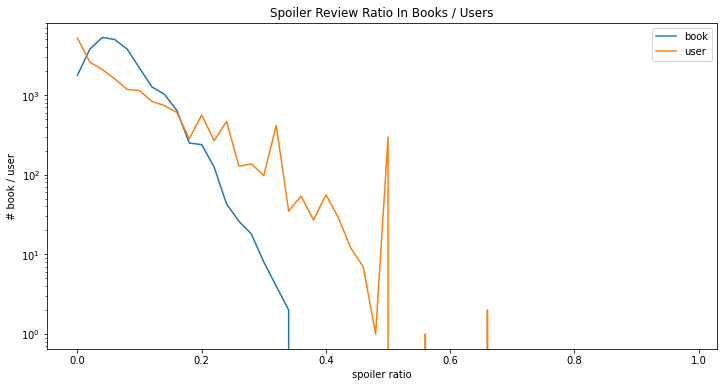

In [ ]:
fig = plt.figure(figsize=(12, 6))
result = plot(list(spoiler_ratio_book.values()))
y = []
X = []
for key in range(50):
    y.append(key/50)
    X.append(result.get(key, 0))
plt.plot(y, X, label='book')
result = plot(list(spoiler_ratio_user.values()))
y = []
X = []
for key in range(50):
    y.append(key/50)
    X.append(result.get(key, 0))
plt.plot(y, X, label='user')
plt.ylabel('# book / user')
plt.xlabel('spoiler ratio')
plt.yscale('log', nonposy='clip')
plt.title("Spoiler Review Ratio In Books / Users")
plt.legend()
plt.show()


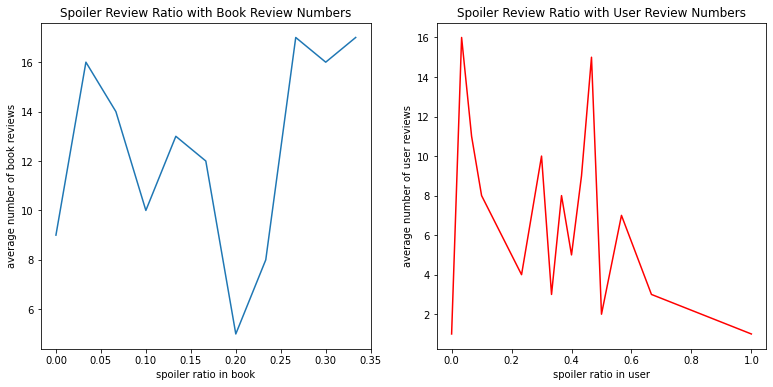

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))

review_num_to_ratio = {}
for book in review_num_book:
    review_num_to_ratio[int(spoiler_ratio_book.get(book,0)*30)] = review_num_book.get(book,0)
keys = list(review_num_to_ratio.keys())
for num in keys:
    review_num_to_ratio[num] = np.mean(review_num_to_ratio[num])
X = sorted(list(review_num_to_ratio.keys()))
y = []
for x in X:
    y.append(review_num_to_ratio[x])
ax[0].plot(np.array(X)/30, y)
ax[0].set_xlabel('spoiler ratio in book')
ax[0].set_ylabel('average number of book reviews')
ax[0].set_title("Spoiler Review Ratio with Book Review Numbers")


review_num_to_ratio_user = {}
for book in review_num_user:
    review_num_to_ratio_user[int(spoiler_ratio_user.get(book,0)*30)] = review_num_user.get(book,0)
keys = list(review_num_to_ratio_user.keys())
for num in keys:
    review_num_to_ratio_user[num] = np.mean(review_num_to_ratio_user[num])
X = sorted(list(review_num_to_ratio_user.keys()))
y = []
for x in X:
    y.append(review_num_to_ratio_user[x])
ax[1].plot(np.array(X)/30, y, color='red')
ax[1].set_xlabel('spoiler ratio in user')
ax[1].set_ylabel('average number of user reviews')
ax[1].set_title("Spoiler Review Ratio with User Review Numbers")
plt.show()

There appears to be a negative correlation between the number of book revies and the spoiler ratio of book reviews. This suggests that when there are more reviews then readers tend to not write spoiler reviews. Another possible explanation may be that when the number of reviews for a particular book grows, the spoiler ratio decreases to match 

## EDA on subset data

In [ ]:
sub_df = df[df.year>=2011].sample(20000,random_state=21)

Example of a review that did not contain a spoiler tag

In [ ]:
from tabulate import tabulate
part = pd.DataFrame(sub_df[sub_df.has_spoiler == 0].review[-3:])

print(part.values)

[["meh... just not feeling it, but I think it's my mood. I may try again in the future, for now it's dnf"]
 ["** spoiler alert ** The later books in this series are something of a blur in my memory, but this felt a bit more readable. A less fae-centric plot helped. The cast of supporting characters, however, is beginning to feel so large that the book sometimes seems like a long series of cameo. Oh, there's Bill! And here's Amelia and Bob! And so on. In a spoilery note, Harris has clearly written herself out the corner she wrote herself into with the whole Eric-Sookie thing, and the love triangle is definitely going to be back on in the next book. Probably a series that has gone on a few too many books to far at this point, but who am I kidding? I'll keep picking them up as I go on. We all need fluff reading."]
 ["ANDREW PARRISH you gorgeous motherf*** (pardon my French) you almost gave me a heart attack!!! I freakin' love that guy. Camryn is a 20 year old girl who just had about enoug

Example of a review that contained spoiler tag

In [ ]:
from tabulate import tabulate
part = pd.DataFrame(sub_df[sub_df.has_spoiler == 1].review[:3])

print(part.values)

[["The parts of the story about Rill's family and childhood were interesting, albeit devastating; the plotline of the Staffords not wanting a family secret revealed as if anyone would care that a senator's mother was adopted as a child ! Your heart breaks for Rill and her siblings particularly Camellia , but you have a hard time caring about Avery's situation."]
 ["It seemed they were growing apart with all the drama and secrets, so Jacob's  new found psychic talents   have given them common ground again."]
 ['"Miaka shook her head. "I\'ll write it down, but it\'s unlikely. If it were that simple, Elizabeth would have killed dozens of men by now." "Not dozens!" she protested. "But, yes, I\'ve shared plenty of...fluids with human men. And other have done that before us. Nothing like this has come of it." "Anyone who could make Akinli smile like that...and he shaved today. He asked me about cutting his hair" -Julie (AKINLI YOU LIL BBY I LOVE YOU.) that moment when the TV was talking abou

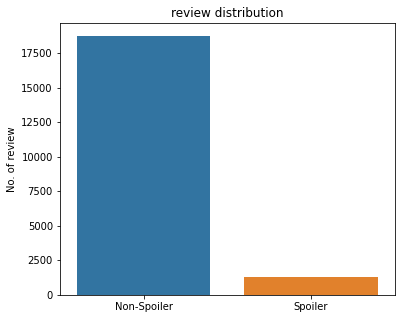

In [ ]:
count_sen = sub_df.has_spoiler.value_counts().reset_index()
count_sen['index'] = ['Non-Spoiler', 'Spoiler']

fig, ax = plt.subplots(1, 1, figsize=(6,5))
sns.barplot(x='index', y='has_spoiler', data=count_sen, ax=ax)
ax.set(xlabel=None, ylabel='No. of review', title='review distribution');

There are totally 18736 (93.68%) non-spoiler reviews and 1264 (6.32%) spoiler reviews in subset data. This histogram shows that our data is quite imbalanced

### Exploring Review Length

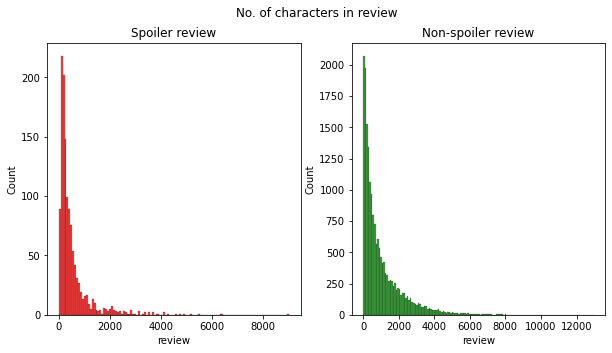

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
cha_len=sub_df[sub_df['has_spoiler']==1]['review'].str.len()
sns.histplot(cha_len, color='red', ax=ax[0])
ax[0].set_title('Spoiler review')
cha_len=sub_df[sub_df['has_spoiler']==0]['review'].str.len()
sns.histplot(cha_len,color='green', ax=ax[1])
ax[1].set_title('Non-spoiler review')
fig.suptitle('No. of characters in review')
plt.show()

The two distributions are similar, indicating that the number of characters per review has little correlation with whether or not a spoiler appears in a review

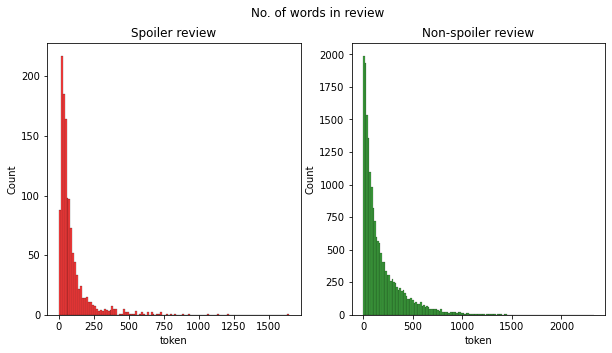

In [ ]:
sub_df['token'].map(lambda x: len(x))

fig, ax = plt.subplots(1,2,figsize=(10,5))
word_len=sub_df[sub_df['has_spoiler']==1]['token'].map(lambda x: len(x))
sns.histplot(word_len,color='red', ax=ax[0])
ax[0].set_title('Spoiler review')
word_len=sub_df[sub_df['has_spoiler']==0]['token'].map(lambda x: len(x))
sns.histplot(word_len,color='green', ax=ax[1])
ax[1].set_title('Non-spoiler review')
fig.suptitle('No. of words in review')
plt.show()


The two distributions are similar, indicating that the number of words per review has little correlation with whether or not a spoiler appears in a review

### ratings

Text(0.5, 1.0, 'Distribution of ratings for reviews without spoilers')

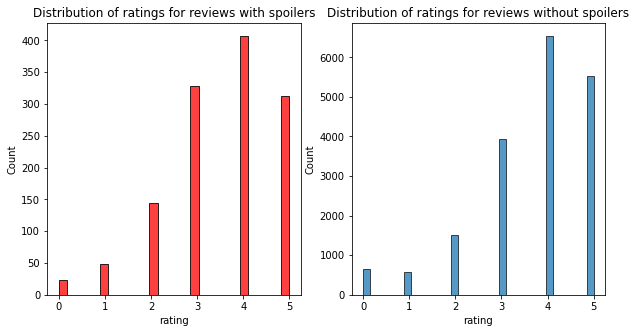

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

spoiler_ratings = sns.histplot(sub_df[sub_df['has_spoiler']==1]['rating'],ax=ax[0],color='red')
ax[0].set_title('Distribution of ratings for reviews with spoilers')
non_spoiler_ratings = sns.histplot(sub_df[sub_df['has_spoiler']==0]['rating'],ax=ax[1])
ax[1].set_title('Distribution of ratings for reviews without spoilers')


In [ ]:
(sub_df[sub_df['has_spoiler']==1]['rating']).value_counts()

4    407
3    329
5    313
2    144
1     48
0     23
Name: rating, dtype: int64

In [ ]:
print(((23 / spoiler_total)*100),'percentage of 0 ratings')
print(((48 / spoiler_total)*100),'percentage of 1 ratings')
print(((144 / spoiler_total)*100),'percentage of 2 ratings')
print(((329 / spoiler_total)*100),'percentage of 3 ratings')
print(((407 / spoiler_total)*100),'percentage of 4 ratings')
print(((313 / spoiler_total)*100),'percentage of 5 ratings')

1.8196202531645569 percentage of 0 ratings
3.79746835443038 percentage of 1 ratings
11.39240506329114 percentage of 2 ratings
26.02848101265823 percentage of 3 ratings
32.199367088607595 percentage of 4 ratings
24.7626582278481 percentage of 5 ratings


In [ ]:
(sub_df[sub_df['has_spoiler']==0]['rating']).value_counts()

4    6540
5    5524
3    3924
2    1512
0     649
1     587
Name: rating, dtype: int64

In [ ]:
print(((649 / non_spoiler_total)*100),'percentage of 0 ratings')
print(((587 / non_spoiler_total)*100),'percentage of 1 ratings')
print(((1512 / non_spoiler_total)*100),'percentage of 2 ratings')
print(((3924 / non_spoiler_total)*100),'percentage of 3 ratings')
print(((6540 / non_spoiler_total)*100),'percentage of 4 ratings')
print(((5524 / non_spoiler_total)*100),'percentage of 5 ratings')

3.463919726729291 percentage of 0 ratings
3.1330059777967554 percentage of 1 ratings
8.07002561912895 percentage of 2 ratings
20.943637916310845 percentage of 3 ratings
34.90606319385141 percentage of 4 ratings
29.48334756618275 percentage of 5 ratings


There doesn't seem to be a distinct convincing relationship between the rating of the book and whether or not the review contained a spoiler. The distribution of ratings is similar in the respective histograms and confirmed when looking at the specific percentage breakdowns

### Word Cloud

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
more_stopwords = ['I', 'The', 'And', 'Im', 'But', 'It', 'didnt', 'one', 'would', 'dont', 'could', 'much', 'wasnt', 'doesnt',
                  'cant','also','get','going','still','She']
stop_words = stop_words + more_stopwords

def remove_stopwords(token):
    text = [word for word in token if word not in stop_words]
    return text
    
sub_df['token'] = sub_df['token'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def create_corpus_df(df, has_spoiler):
    corpus=[]
    
    for x in df.token[df['has_spoiler']==has_spoiler]:
        for i in x:
            corpus.append(i)
    return corpus

#### Most Common Words in Spoiler reviews

In [ ]:
corpus_spoiler_review = create_corpus_df(sub_df, 1)

dict = {}
for word in corpus_spoiler_review:
    dict[word] = dict.get(word, 0) + 1
        
top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:20]
temp = pd.DataFrame(top)
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,book,624
1,like,520
2,really,420
3,end,325
4,even,271
5,know,257
6,love,257
7,think,245
8,see,243
9,story,235


The most common words that appear in spoiler reviews are book, like, really, end, even know. This was not super insightful, as these words don't convey strong sentiments 

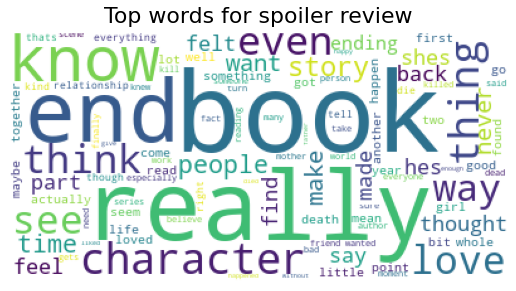

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=100 
)

clean_text = [' '.join(item) for item in sub_df[sub_df.has_spoiler == 1].token]
wc.generate(' '.join(text for text in clean_text))
plt.figure(figsize=(9,5))
plt.title('Top words for spoiler review', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

#### Most Common words in Non-Spoiler Reviews

In [ ]:
corpus_spoiler_review = create_corpus_df(sub_df, 0)

dict = {}
for word in corpus_spoiler_review:
    dict[word] = dict.get(word, 0) + 1
        
top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:20]
temp = pd.DataFrame(top)
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,book,34214
1,like,14958
2,read,14637
3,story,13915
4,really,13188
5,love,10517
6,characters,9521
7,This,8962
8,series,6971
9,time,6856


Similar to the spoiler reviews, the most common words in non-spoiler reviews are book, like, read, story. Again, not super insightful so it would be worth exploring a sentiment analysis for more conclusive insights in the future

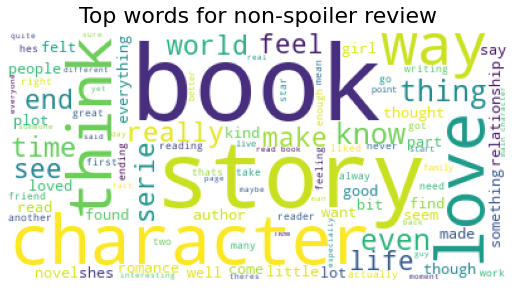

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=100
)

clean_text = [' '.join(item) for item in sub_df[sub_df.has_spoiler == 0].token]
wc.generate(' '.join(text for text in clean_text))
plt.figure(figsize=(9,5))
plt.title('Top words for non-spoiler review', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()